<a href="https://colab.research.google.com/github/tomersk/python-applications/blob/main/04_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4.1 Infiltration Method
Method to estimate abstraction arises from infiltration under variable rainfall intensity is based on Green-Ampt infiltration equation. When infiltration rate is more than rainfall intensity or in absence of ponding, cumulative infiltration is calculated from cumulative rainfall. If infiltration rateis less than rainfall intensity, ponding will take place. 
According to Green-Ampt Infiltration Equation: 


*  Cumulative Infiltration ${F_{t+\Delta t}}$

     ${F_{t+\Delta t}} = F_t + K\Delta t + \Psi \Delta θ ln \frac{F_{t+\Delta t}+ \Psi \Delta θ}{F_t+ \Psi \Delta θ}$ 
*   Infiltration Rate ${f_{t+\Delta t}}$
    
     ${f_{t+\Delta t}} =  K (\frac{\Psi \Delta θ}{F_{t+\Delta t}} + 1) $ 



 

In [11]:
## Source: https://github.com/csdms-contrib/GreenAmptInfiltrationModel ##
from scipy.optimize import newton
from pprint import pprint
from json import dump
from math import log
import numpy as np
import matplotlib.pyplot as plt

class GreenAmpt(object):
    '''
    Green-Ampt Cumulative Infiltration 
    '''
        
    def __init__(self, K, dt, dtheta, psi, i):
        """
        Constructor
        """
        self.K       = K                 # hydraulic conductivity
        self.dt      = dt                # time resolution
        #self.theta_i = theta_i           # initial water content
        #self.theta_s = theta_s           # saturated water content
        self.dtheta  = dtheta #theta_s - theta_i # the change in the moisture content
        self.psi     = psi               # wetting front soil suction head
        if type(i) == list:
            self.i = i                   # rainfall intensity
        else:
            self.i = [i]
    
    def Fp(self, i):
        """
        Cumulative infiltration at the ponding time tp
        """
        return self.K * self.psi * self.dtheta / (i - self.K) 
    
    def F(self, F_t, dt_t):
        """
        Solve Equation of Green-Ampt Cumulative Infiltration __EqnF
        """
        F_t_next = lambda F: self.__EqnF(F_t, dt_t, F)
        return newton(F_t_next, 3)
    
    def f(self, F):
        """
        Generate Green-Ampt Infiltration Rate at time t
        """
        if F == 0:
            return -9999
        else:
            return self.K * (self.psi * self.dtheta / F + 1)    
        
    def __EqnF(self, F_t, dt_t, F):
        """
        Equation of Green-Ampt Cumulative Infiltration after ponding
        F:  Green-Ampt Cumulative Infiltration variable 
        """
        return F - F_t - self.K*dt_t - self.psi*self.dtheta*log((self.psi*self.dtheta+F)/(self.psi*self.dtheta+F_t))
    
    def F_f(self):
        """
        Generate the time series of cumulative infiltration and infiltration rate
        given the time series of rainfall intensity i
        """
        t_len = len(self.i)
        F_all = []; f_all = []; t_all = []
        # initial
        F_all.append(0)
        f_all.append(-9999)
        t_all.append(0)
        for ind in range(1, t_len+1):
            i_t = self.i[ind-1]
            f_t = f_all[ind-1]
            F_t = F_all[ind-1]
            if abs(f_t) <= i_t:
                # ponding occurs throught interval
                F_t_next = self.F(F_t, self.dt)
                f_t_next = self.f(F_t_next)
            elif abs(f_t) > i_t:
                # no ponding at the beginning of the interval
                F_t_next_temp = F_t + i_t*self.dt
                f_t_next_temp = self.f(F_t_next_temp)
                if abs(f_t_next_temp) > i_t:
                    # no ponding throughout interval
                    f_t_next = f_t_next_temp
                    F_t_next = F_t_next_temp
                elif abs(f_t_next_temp) <= i_t:
                    # ponding occurs during interval
                    Fp_t = self.Fp(i_t)
                    print(i_t)
                    dt_p = (Fp_t - F_t) / i_t
                    F_t_next = self.F(Fp_t, self.dt - dt_p)
                    f_t_next = self.f(F_t_next)        
            F_all.append(F_t_next)
            f_all.append(f_t_next)
            t_all.append(self.dt*(ind))        
        return F_all, f_all, t_all

Example: V.T.Chow Example 5.4.1
Solutio: 

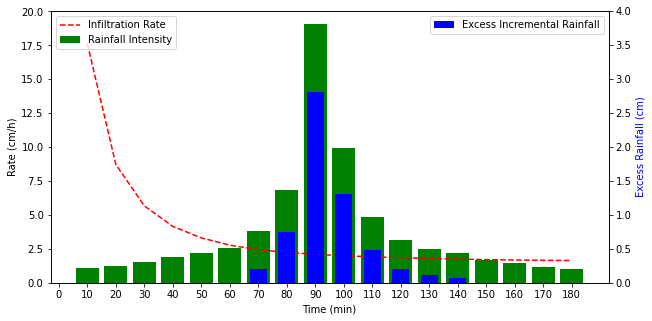

In [133]:
    K = 1.09; psi = 11.01; dtheta = 0.247; dt = 0.166 ; dt_min = 10;
    i = [1.08, 1.26, 1.56, 1.92, 2.22, 2.58, 3.84, 6.84, 19.08, \
         9.90, 4.86, 3.12, 2.52, 2.16, 1.68, 1.44, 1.14, 1.02]
    a = GreenAmpt(K, dt, dtheta, psi, i)
    F, f, t =a.F_f()

    incre_i = [x * dt for x in i]
    #print(incre_i)
    cum_i = []
    cum_i = [sum(incre_i[0:x:1]) for x in range(0, len(incre_i)+1)]
    #print(cum_i)
    #print(F)
    cum_excess_rain = np.array(cum_i)-np.array(F)
    #print(cum_excess_rain)
    excess_rain = [cum_excess_rain[x+1]-cum_excess_rain[x] for x in range(0, len(cum_excess_rain)-1)]
    #print(excess_rain)
    t_min = np.arange(0,(len(i)+1)*dt_min,dt_min)
    #print(t_min)
###### Plotting
    fig, ax = plt.subplots(figsize = (10, 5))
    ax2 = ax.twinx()
    ax.bar(t_min[1:19],i,color = 'g',width = 8)
    ax2.bar(t_min[1:19],excess_rain,color = 'b',width = 6)
    ax.plot(t_min[1:19],f[1:],'--r') 
    ax.set_xlabel('Time (min)')
    ax.set_ylabel('Rate (cm/h)')
    ax2.set_ylabel('Excess Rainfall (cm)',color = 'b')
    ax2.set_ylim([0, 4])
    ax.legend(["Infiltration Rate","Rainfall Intensity"],loc = 'upper left')
    ax2.legend(["Excess Incremental Rainfall"],loc='upper right')
    ax.set_xticks(t_min)
    #ax.bar(x, y1, color = 'g')
    #ax2.bar(x, y2, color = 'b')
    plt.show()